## Useful code for processing test data

### Imports

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

### Time test for files

In [127]:
def show_time_plot_for_file(TEST_FILES, DUMMY_FILE):
    with open(DUMMY_FILE) as file:
        dummy_values = np.array(file.read().split()).astype(float)

    df_time = pd.DataFrame()
    df_cycles = pd.DataFrame()

    for filename, plot_name in TEST_FILES:
        times = []
        cycles = []
        with open(filename) as file:
            for line in file:
                time, cycle = map(float, line.split())
                times.append(time)
                cycles.append(cycle)

        times = np.array(times) - dummy_values[0]
        cycles = np.array(cycles) - dummy_values[1]

        mask = np.ones(len(times), dtype=bool)
        mask[np.argmin(times)] = mask[np.argmax(times)] = False
        times = times[mask]
        
        mask = np.ones(len(cycles), dtype=bool)
        mask[np.argmin(cycles)] = mask[np.argmax(cycles)] = False
        cycles = cycles[mask]

        df_time[plot_name] = pd.DataFrame(times)
        df_cycles[plot_name] = pd.DataFrame(cycles)

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))

    df_time.boxplot(ax=axes[0], grid=False)
    axes[0].set_title('Time Duration [sec]')
    axes[0].grid(axis='y')

    df_cycles.boxplot(ax=axes[1], grid=False)
    axes[1].set_title('Processor Cycles')
    axes[1].grid(axis='y')

    plt.tight_layout()
    plt.show()

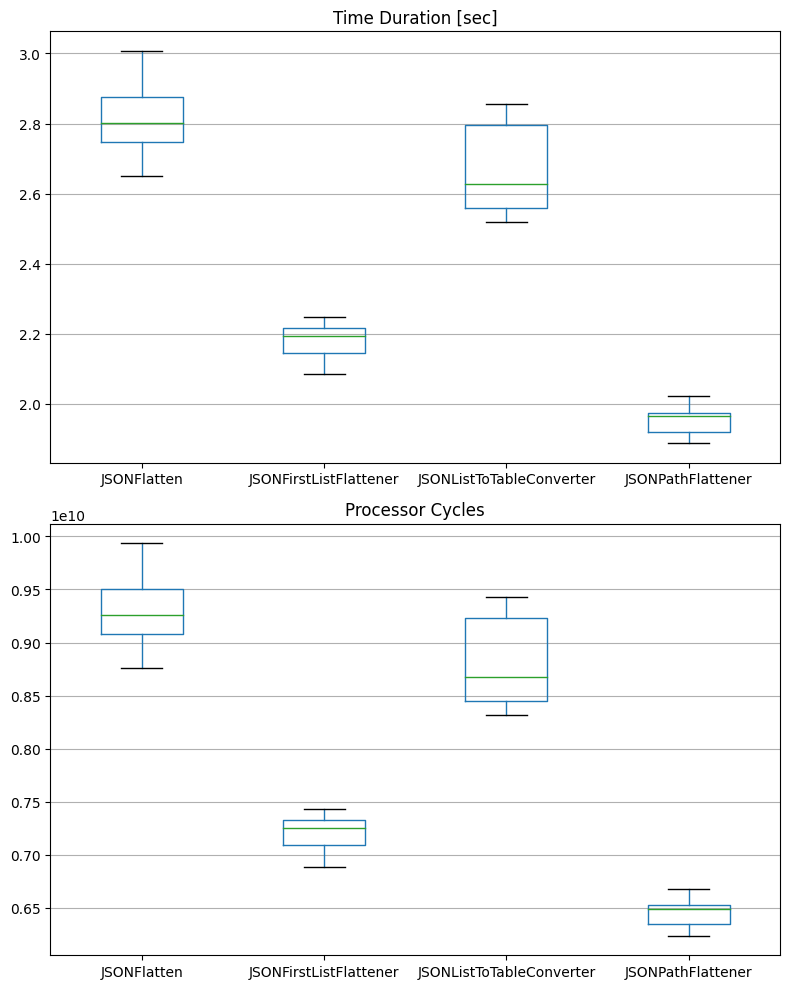

In [128]:
# AIRLINES-100000
test_name = "AIRLINES-100000"
TEST_FILES = [
    (f"time/files/{test_name}-JSONFlatten.txt", "JSONFlatten"),
    (f"time/files/{test_name}-JSONFirstListFlattener.txt", "JSONFirstListFlattener"),
    (f"time/files/{test_name}-JSONListToTableConverter.txt", "JSONListToTableConverter"),
    (f"time/files/{test_name}-JSONPathFlattener.txt", "JSONPathFlattener"),
]

DUMMY_FILE = f"time/files/{test_name}-JSONDummy.txt"
show_time_plot_for_file(TEST_FILES, DUMMY_FILE)

### Time measures with ballooner

In [129]:
MAX_MEASURES = 12
DIRECTORY_PATH = "time/"
txt_files = glob.glob(os.path.join(DIRECTORY_PATH, "*.txt"))
files = [os.path.basename(file) for file in txt_files]

main_time_dict = {}
""" example structure
{
    ('nasa', '100000', '15000'): {
        'json_dummy': [80.9, 75.025, 77.25, 56.425],
        'json_first_list_flattener': [81.92, 70.76, 76.575, 58.025, 77.8, 68.9]
    },
    ('nasa', '1000000', '12000'): {
        'json_dummy': [78.46, 90.97, 80.784, 88.621]
    }
}
"""

for filename in files:
    file_tags = filename.split("-")
    time_key = (file_tags[0], file_tags[1]) # dataset, dataset_size
    flatter_key = file_tags[2] # flatter_method

    if time_key not in main_time_dict:
        main_time_dict[time_key] = {}

    with open(DIRECTORY_PATH + filename) as file:
        data = np.array(file.read().split()).astype(float)
        if len(data) > MAX_MEASURES:
            data = data[-MAX_MEASURES:]  # Take only the last 12 measures
        main_time_dict[time_key][flatter_key] = data

print("Keys of main_time_dict:")
for key in main_time_dict.keys():
    print(key)

def draw_time_plot(key: tuple):
    if key not in main_time_dict.keys():
        print(f"Key {key} not found!")
        return

    measurements = main_time_dict[key].copy()
    DUMMY_KEY = "json_dummy.txt"
    if DUMMY_KEY not in measurements.keys():
        print(f"DUMMY_KEY not found!")
        return

    dummy_values = measurements[DUMMY_KEY]
    measurements.pop(DUMMY_KEY)

    if (dummy_values is None or len(dummy_values) < 1):
        print("No dummy measures!")
        return

    df_time_duration = pd.DataFrame()
    for method, time in measurements.items():
        unclean_values = np.array(time).astype(float)
        while len(dummy_values) < len(unclean_values):
            dummy_values = np.append(dummy_values, dummy_values[-1])

        values = unclean_values - dummy_values[:len(unclean_values)]

        mask = np.ones(len(values), dtype=bool)
        mask[np.argmin(values)] = mask[np.argmax(values)] = False
        mask = values > 0
        values = values[mask]

        df_time_duration[method] = pd.DataFrame(values)

    axes = df_time_duration.boxplot(figsize=(8,5), grid=False)
    # axes.set_yscale('log')
    axes.grid(axis='y')
    plt.tight_layout()
    plt.show()


Keys of main_time_dict:


In [130]:
# draw_time_plot(('airlines', '1000000'))
# draw_time_plot(('movies', '1000000'))
# draw_time_plot(('nasa', '1000000'))

draw_time_plot(('gists', '100000'))
draw_time_plot(('reddit', '10000'))

Key ('gists', '100000') not found!
Key ('reddit', '10000') not found!
